In [7]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import shap
import warnings
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os
from nltk.tokenize import word_tokenize

warnings.filterwarnings("ignore")

nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

script_start_time = time.time()

In [8]:
start_time = time.time()
twitter_df = pd.read_csv("C:/Users/arpit/Documents/Twitter_Data.csv")
reddit_df = pd.read_csv("C:/Users/arpit/Documents/Reddit_Data.csv")

reddit_df.rename(columns={"clean_comment": "text", "category": "label"}, inplace=True)
reddit_df["source"] = "Reddit"

twitter_df.rename(columns={"clean_text": "text", "category": "label"}, inplace=True)
twitter_df["source"] = "Twitter"

combined_df = pd.concat([reddit_df, twitter_df], ignore_index=True)

print("Combined Dataset Shape:", combined_df.shape)
print(combined_df.head())

combined_df.to_csv("combined_sentiment_dataset.csv", index=False)

df = combined_df.copy()

df['text'] = df['text'].fillna('').astype(str)

print ('_____________________________________________')

print(f"✅ Data Loading Time: {time.time() - start_time:.2f} seconds")

Combined Dataset Shape: (200229, 3)
                                                text  label  source
0   family mormon have never tried explain them t...    1.0  Reddit
1  buddhism has very much lot compatible with chr...    1.0  Reddit
2  seriously don say thing first all they won get...   -1.0  Reddit
3  what you have learned yours and only yours wha...    0.0  Reddit
4  for your own benefit you may want read living ...    1.0  Reddit
_____________________________________________
✅ Data Loading Time: 2.70 seconds



============================== Exploratory Data Analysis ==============================

--- Univariate Analysis ---


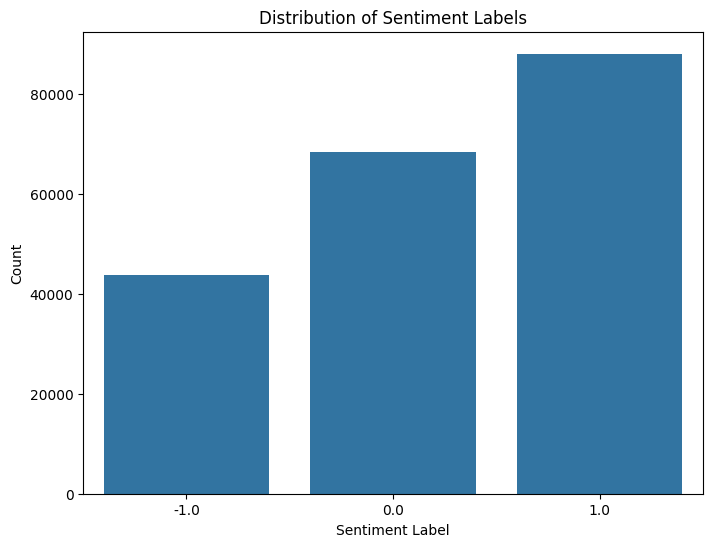

Sentiment Label Distribution (Normalized):
label
 1.0    0.439912
 0.0    0.341396
-1.0    0.218692
Name: proportion, dtype: float64


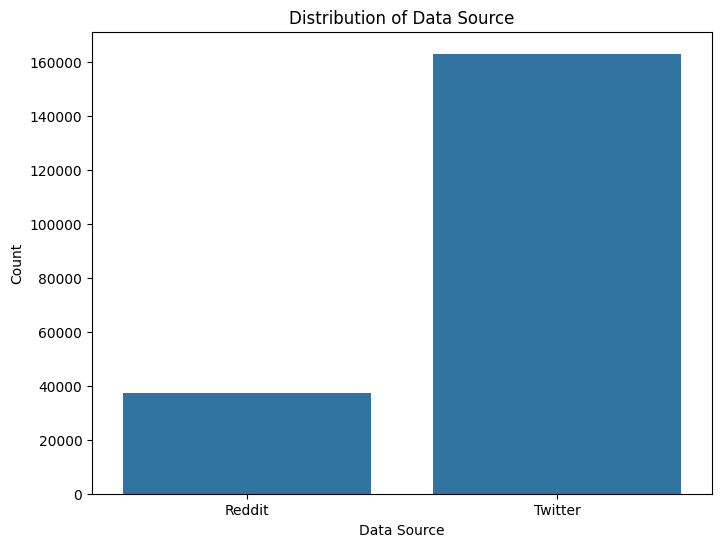


Data Source Distribution (Normalized):
source
Twitter    0.813968
Reddit     0.186032
Name: proportion, dtype: float64


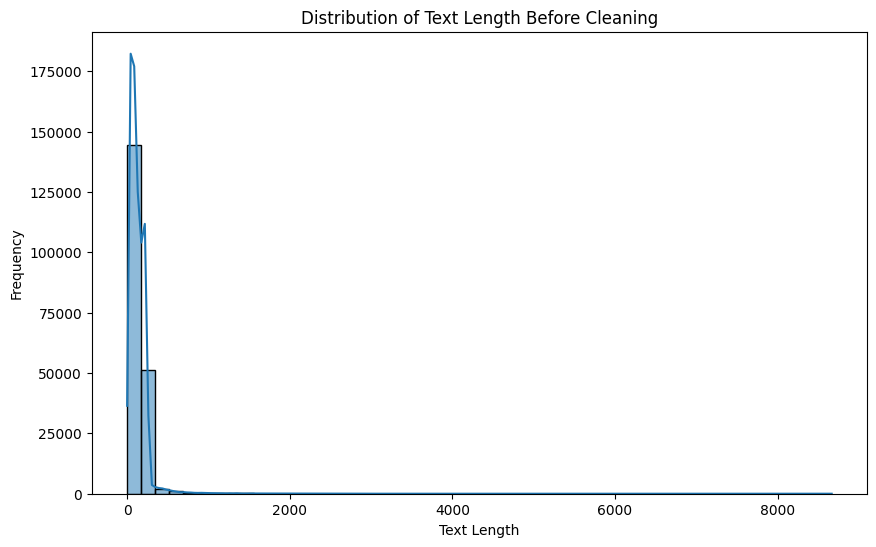


Text Length Before Cleaning Statistics:
count    200229.000000
mean        134.726723
std         167.623831
min           0.000000
25%          61.000000
50%         109.000000
75%         183.000000
max        8665.000000
Name: text_length_before_cleaning, dtype: float64

--- Bivariate Analysis ---


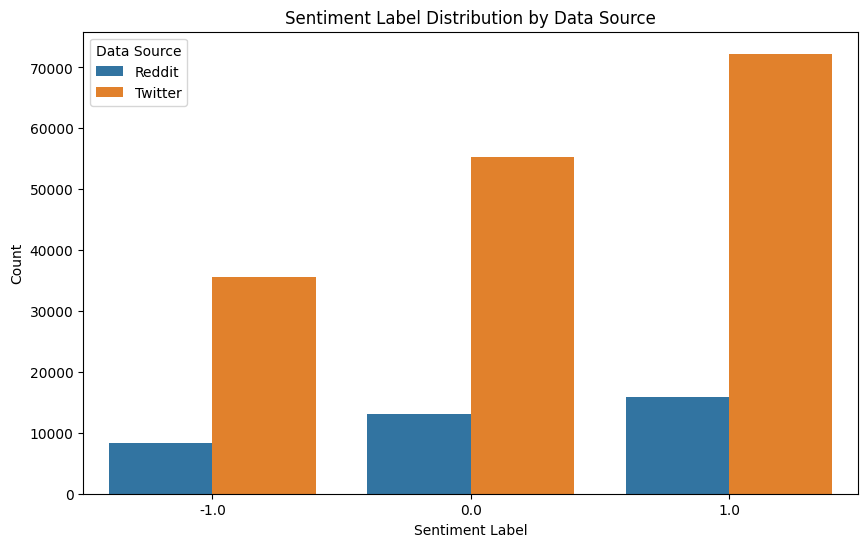


Sentiment Label vs. Data Source (Normalized by Label):
source    Reddit   Twitter
label                     
-1.0    0.189029  0.810971
 0.0    0.192261  0.807739
 1.0    0.179723  0.820277


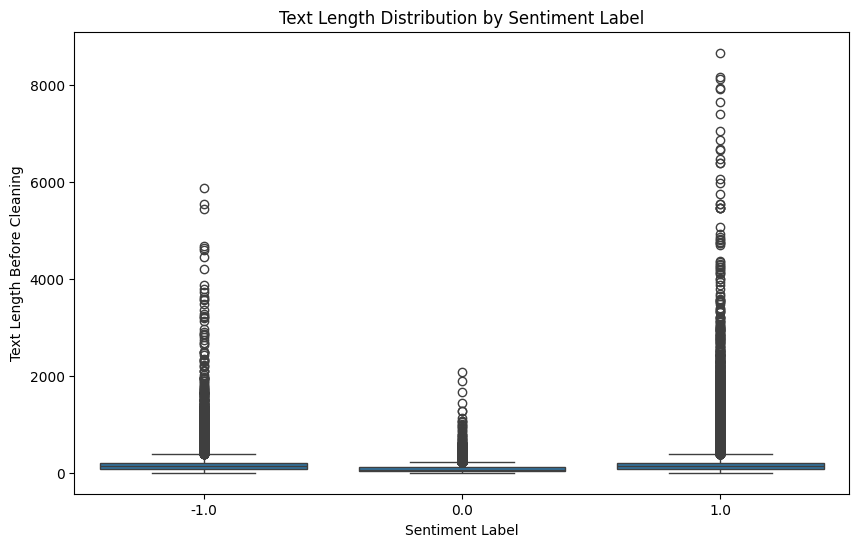


Text Length Statistics by Sentiment Label:
         count        mean         std  min   25%    50%    75%     max
label                                                                  
-1.0   43787.0  160.510928  158.803669  0.0  87.0  145.0  209.0  5875.0
 0.0   68355.0   82.648438   63.061613  0.0  39.0   66.0  110.0  2074.0
 1.0   88080.0  162.328565  212.258413  0.0  80.0  136.0  204.0  8665.0

--- Multivariate Analysis ---


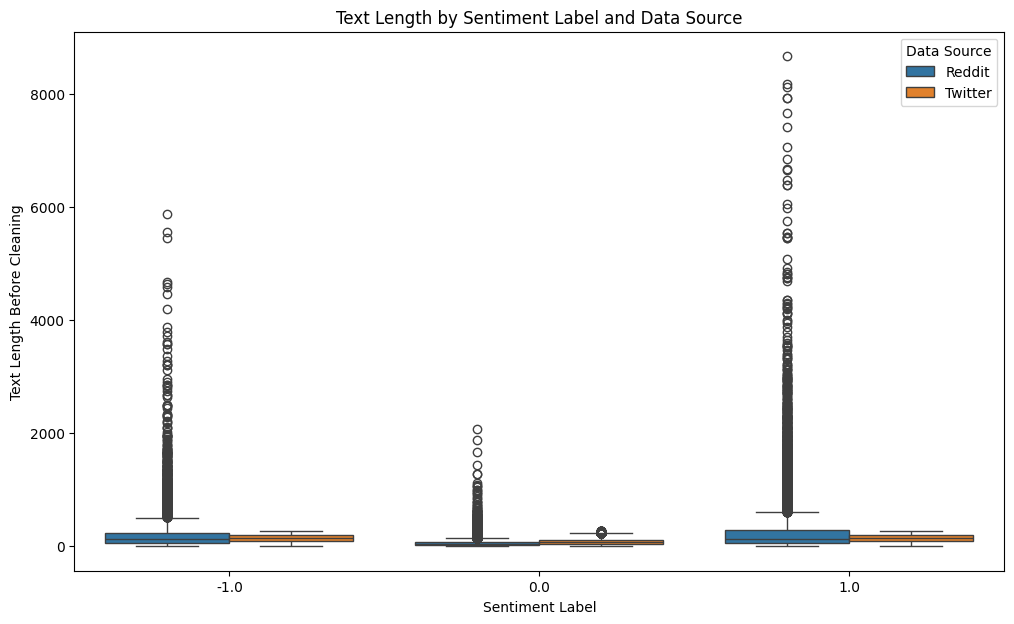


============================== EDA Finished ==============================


In [9]:
# ---------------------------------------------
# 📊 3. Exploratory Data Analysis (EDA)
# ---------------------------------------------
def perform_eda(df_eda, save_path='eda_plots'):
    print("\n" + "="*30 + " Exploratory Data Analysis " + "="*30)
    os.makedirs(save_path, exist_ok=True)

    # --- Univariate Analysis ---
    print("\n--- Univariate Analysis ---")

    # Label Distribution
    plt.figure(figsize=(8, 6))
    sns.countplot(x='label', data=df_eda)
    plt.title('Distribution of Sentiment Labels')
    plt.xlabel('Sentiment Label')
    plt.ylabel('Count')
    plt.savefig(os.path.join(save_path, 'label_distribution.png'))
    plt.show()
    print("Sentiment Label Distribution (Normalized):")
    print(df_eda['label'].value_counts(normalize=True))

    # Source Distribution
    if 'source' in df_eda.columns:
        plt.figure(figsize=(8, 6))
        sns.countplot(x='source', data=df_eda)
        plt.title('Distribution of Data Source')
        plt.xlabel('Data Source')
        plt.ylabel('Count')
        plt.savefig(os.path.join(save_path, 'source_distribution.png'))
        plt.show()
        print("\nData Source Distribution (Normalized):")
        print(df_eda['source'].value_counts(normalize=True))

    # Text Length Before Cleaning
    df_eda['text_length_before_cleaning'] = df_eda['text'].apply(len)
    plt.figure(figsize=(10, 6))
    sns.histplot(df_eda['text_length_before_cleaning'], bins=50, kde=True)
    plt.title('Distribution of Text Length Before Cleaning')
    plt.xlabel('Text Length')
    plt.ylabel('Frequency')
    plt.savefig(os.path.join(save_path, 'text_length_before_cleaning.png'))
    plt.show()
    print("\nText Length Before Cleaning Statistics:")
    print(df_eda['text_length_before_cleaning'].describe())

    # --- Bivariate Analysis ---
    print("\n--- Bivariate Analysis ---")

    # Label vs. Source
    if 'source' in df_eda.columns:
        plt.figure(figsize=(10, 6))
        sns.countplot(x='label', hue='source', data=df_eda)
        plt.title('Sentiment Label Distribution by Data Source')
        plt.xlabel('Sentiment Label')
        plt.ylabel('Count')
        plt.legend(title='Data Source')
        plt.savefig(os.path.join(save_path, 'label_vs_source.png'))
        plt.show()
        print("\nSentiment Label vs. Data Source (Normalized by Label):")
        print(pd.crosstab(df_eda['label'], df_eda['source'], normalize='index'))

    # Label vs. Text Length
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='label', y='text_length_before_cleaning', data=df_eda)
    plt.title('Text Length Distribution by Sentiment Label')
    plt.xlabel('Sentiment Label')
    plt.ylabel('Text Length Before Cleaning')
    plt.savefig(os.path.join(save_path, 'label_vs_text_length.png'))
    plt.show()
    print("\nText Length Statistics by Sentiment Label:")
    print(df_eda.groupby('label')['text_length_before_cleaning'].describe())

    # --- Multivariate Analysis ---
    print("\n--- Multivariate Analysis ---")

    # (Example) Label vs. Text Length vs. Source
    if 'source' in df_eda.columns:
        plt.figure(figsize=(12, 7))
        sns.boxplot(x='label', y='text_length_before_cleaning', hue='source', data=df_eda)
        plt.title('Text Length by Sentiment Label and Data Source')
        plt.xlabel('Sentiment Label')
        plt.ylabel('Text Length Before Cleaning')
        plt.legend(title='Data Source')
        plt.savefig(os.path.join(save_path, 'label_vs_text_length_vs_source.png'))
        plt.show()

    print("\n" + "="*30 + " EDA Finished " + "="*30)
    return

# Perform EDA
eda_df = df.copy()
perform_eda(eda_df)
del eda_df

In [10]:
# ---------------------------------------------
# 🧹 4. Text Cleaning (Optimized)
# ---------------------------------------------

start_time = time.time()
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text_optimized(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r'[^A-Za-z\s]', '', text.lower())
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return " ".join(tokens)

df['clean_text'] = df['text'].apply(clean_text_optimized)
df = df[df['clean_text'].str.len() > 0].copy()

print(f"✅ Text Cleaning Time: {time.time() - start_time:.2f} seconds")
print ('_____________________________________________')
print(f"✅ Sample Cleaned Texts:\n{df['clean_text'].sample(5, random_state=42)}")
print ('_____________________________________________')
print(f"✅ Rows after cleaning: {df.shape[0]}")

✅ Text Cleaning Time: 88.50 seconds
_____________________________________________
✅ Sample Cleaned Texts:
124039    top trending today india rowling dragon ball s...
34131                                      odds bsp winning
6274      warmest year far india never reach gdp growth ...
127363    latest modi lenge azaadi student chant slogan ...
60413     mrjaitley people dont remember modi given anyt...
Name: clean_text, dtype: object
_____________________________________________
✅ Rows after cleaning: 199726


In [11]:
# ---------------------------------------------
# ✨ 5. Handle NaN in Label and Encode
# ---------------------------------------------
print("Number of NaN values in 'label' column before handling:", df['label'].isnull().sum())
print ('_____________________________________________')
df.dropna(subset=['label'], inplace=True)
print("Number of NaN values in 'label' column after handling:", df['label'].isnull().sum())
print ('_____________________________________________')
print("Shape of DataFrame after handling NaN in 'label':", df.shape)

label_mapping = {-1.0: 0, 0.0: 1, 1.0: 2}
df['label_encoded'] = df['label'].map(label_mapping).astype(int)
y = df['label_encoded']

Number of NaN values in 'label' column before handling: 7
_____________________________________________
Number of NaN values in 'label' column after handling: 0
_____________________________________________
Shape of DataFrame after handling NaN in 'label': (199719, 4)


In [12]:
# ---------------------------------------------
# ✨ 6. TF-IDF Vectorization
# ---------------------------------------------
start_time = time.time()
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['clean_text'])
print(f"✅ TF-IDF Vectorization Time: {time.time() - start_time:.2f} seconds")

✅ TF-IDF Vectorization Time: 8.11 seconds


In [13]:
# ---------------------------------------------
# ✂️ 7. Train-Test Split
# ---------------------------------------------
start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"✅ Train-Test Split Time: {time.time() - start_time:.2f} seconds")
print ('_____________________________________________')
print(f"✅ Training set shape: {X_train.shape}, {y_train.shape}")
print ('_____________________________________________')
print(f"✅ Testing set shape: {X_test.shape}, {y_test.shape}") 

✅ Train-Test Split Time: 0.07 seconds
_____________________________________________
✅ Training set shape: (159775, 5000), (159775,)
_____________________________________________
✅ Testing set shape: (39944, 5000), (39944,)


In [14]:
# ---------------------------------------------
# 🤖 8. Train Multiple Models
# ---------------------------------------------
start_time = time.time()
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear', random_state=42),
    "Naive Bayes": MultinomialNB(),
    "Linear SVM": LinearSVC(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1, random_state=42)
}

model_scores = {}

for name, model in models.items():
    start_train_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_train_time
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    model_scores[name] = acc
    print ('_____________________________________________')
    print(f"✅ {name} Accuracy: {acc:.4f} (Training Time: {train_time:.2f} seconds)")
    print ('_____________________________________________')

best_model_name = max(model_scores, key=model_scores.get)
best_model = models[best_model_name]
print ('_____________________________________________')
print(f"\n🏆 Best Model: {best_model_name} with Accuracy: {model_scores[best_model_name]:.4f}")
print ('_____________________________________________')
print(f"✅ Total Model Training Time: {time.time() - start_time:.2f} seconds")
print ('_____________________________________________')

_____________________________________________
✅ Logistic Regression Accuracy: 0.8834 (Training Time: 6.21 seconds)
_____________________________________________
_____________________________________________
✅ Naive Bayes Accuracy: 0.7147 (Training Time: 0.09 seconds)
_____________________________________________
_____________________________________________
✅ Linear SVM Accuracy: 0.8953 (Training Time: 8.27 seconds)
_____________________________________________
_____________________________________________
✅ Random Forest Accuracy: 0.8490 (Training Time: 344.66 seconds)
_____________________________________________
_____________________________________________
✅ XGBoost Accuracy: 0.8272 (Training Time: 178.15 seconds)
_____________________________________________
_____________________________________________

🏆 Best Model: Linear SVM with Accuracy: 0.8953
_____________________________________________
✅ Total Model Training Time: 539.74 seconds
__________________________________________

In [17]:
# ---------------------------------------------
# 🧠 11. Model Explainability (for the best linear model)
# ---------------------------------------------
start_time = time.time()
if best_model_name == "XGBoost":
    explainer = shap.Explainer(best_model)
    shap_values = explainer(X_test[:100])
    shap.summary_plot(shap_values, features=X_test[:100], feature_names=tfidf.get_feature_names_out())
    plt.savefig(os.path.join('eda_plots', 'shap_summary_plot.png'))
    plt.show()

elif best_model_name in ["Logistic Regression", "Linear SVM"]:
    feature_names = tfidf.get_feature_names_out()
    if hasattr(best_model, 'classes_') and hasattr(best_model, 'coef_'):
        classes = best_model.classes_
        sentiment_labels_explain = {0: "Negative", 1: "Neutral", 2: "Positive"}  # Define sentiment_labels here
        for idx, label in enumerate(classes):
            coef = best_model.coef_[idx]
            top_positive_indices = np.argsort(coef)[-10:]
            top_negative_indices = np.argsort(coef)[:10]

            print(f"\n📊 Top Words for Sentiment Label: {label} ({sentiment_labels_explain.get(label, 'Unknown')}):")
            print("  ➕ Top Positive Contributions:")
            for i in reversed(top_positive_indices):
                print(f"    {feature_names[i]}: {coef[i]:.4f}")
            print("  ➖ Top Negative Contributions:")
            for i in top_negative_indices:
                print(f"    {feature_names[i]}: {coef[i]:.4f}")
    else:
        print("Warning: Model does not have 'classes_' or 'coef_' attribute.")

else:
    print("⚠️ SHAP only supported for XGBoost or linear models in this setup.")
print(f"✅ Model Explainability Time: {time.time() - start_time:.2f} seconds")


📊 Top Words for Sentiment Label: 0 (Negative):
  ➕ Top Positive Contributions:
    worst: 6.8009
    pathetic: 6.1950
    disgusting: 6.0073
    moron: 5.9498
    idiot: 5.8099
    stupid: 5.7250
    hate: 5.6755
    insulting: 5.6471
    bloody: 5.5895
    bad: 5.4310
  ➖ Top Negative Contributions:
    best: -8.2464
    great: -6.3632
    lol: -5.7964
    proud: -5.3204
    many: -4.9470
    brilliant: -4.5487
    brave: -4.5454
    good: -4.4141
    excellent: -4.3356
    better: -4.2981

📊 Top Words for Sentiment Label: 1 (Neutral):
  ➕ Top Positive Contributions:
    serving: 1.1906
    gen: 1.1149
    ltd: 1.0012
    distribution: 0.9683
    recovery: 0.9076
    sanitation: 0.8081
    irani: 0.7591
    possibly: 0.6909
    pop: 0.6849
    cleaning: 0.6726
  ➖ Top Negative Contributions:
    new: -8.2703
    good: -7.3930
    live: -7.3128
    first: -6.6960
    high: -6.2806
    strong: -6.1226
    bad: -6.0454
    great: -5.9975
    best: -5.9780
    full: -5.9357

📊 Top Words 

In [20]:
# 10. Save Predictions for Tableau/Power BI
start_time = time.time()
predictions = best_model.predict(X_test)
label_mapping_reverse = {v: k for k, v in label_mapping.items()} # Reverse mapping for clarity if needed
predicted_sentiments = [label_mapping_reverse.get(pred) for pred in predictions]

# Get the indices of the test set from the train_test_split
_, test_indices = train_test_split(df.index, test_size=0.2, random_state=42) # Use df.index here

results_df = pd.DataFrame({
    'original_text': df.loc[test_indices, 'text'].tolist(), # Use df here
    'cleaned_text': df.loc[test_indices, 'clean_text'].tolist(), # Use df here
    'predicted_label_encoded': predictions.tolist(),
    'predicted_label': predicted_sentiments
})

results_df.to_csv('sentiment_predictions.csv', index=False, encoding='utf-8')
print(f"✅ Sentiment predictions saved to sentiment_predictions.csv (Time: {time.time() - start_time:.2f} seconds)")

✅ Sentiment predictions saved to sentiment_predictions.csv (Time: 0.73 seconds)


In [21]:
# ---------------------------------------------
# 🎉 11. All Done!
# ---------------------------------------------
script_end_time = time.time()
print(f"\n🚀 Sentiment analysis complete! Total Execution Time: {script_end_time - script_start_time:.2f} seconds")


🚀 Sentiment analysis complete! Total Execution Time: 1044.60 seconds
